# imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px


# Function to calculate the CAPM

In [3]:
def merge_dfs(dfs, df_names=None, join="inner", columns=["Close"]):
    """
    Merges a list of dataframes into one. Uses the index as the key and `pd.concat` to merge the dataframes
    Parameters
    ----------
    dfs : list
        List of dataframes to merge
    df_names : list, optional
        Names of the dataframes, by default None Uses this to rename the columns of the merged dataframe
    join : str, optional
        How to join the dataframes, by default "inner"
    columns : str, optional
        Which columns to merge, by default "Close"
    Returns
    -------
    pd.DataFrame
        Merged dataframe
    """

    
    dfs = [df[columns] for df in dfs]
    df = pd.concat(dfs, axis=1, join=join)
    if df_names:
        df.columns = df_names
    else:
        df.columns = [f"df_{i}" for i in range(len(dfs))]
    return df

In [4]:
def cal_beta(merged_dfs, benchmark="snp500", freq="M"):
    """
    Calculates the beta of a list of dataframes
    Parameters
    ----------
    merged_dfs : pd.DataFrame
        Merged dataframe of the dataframes to calculate the beta of
    benchmark : str, optional
        Which column to use as the benchmark, by default "snp500"
    Returns
    -------
    pd.DataFrame
        Dataframe of the beta of each column
    """
    merged_dfs = merged_dfs.asfreq(freq, method="ffill").pct_change().dropna()
    beta = pd.DataFrame()
    for col in merged_dfs.columns:
        if col != benchmark:
            beta.loc[col, "beta"] = merged_dfs[col].corr( merged_dfs[benchmark]) * ( merged_dfs[col].std()/merged_dfs[benchmark].std() )# / np.var(merged_dfs[benchmark])
    return beta

In [5]:
def expected_return(risk_free_rate, beta, market_return):
    """
    Calculate the expected return of a stock

    Parameters
    ----------
    risk_free_rate : float
        Risk free rate
    beta : float
        Beta of the stock in numpy array
    market_return : float
        Expected return of the market

    Returns
    -------
    float
        Expected return of the stock

    """
    expected_return = risk_free_rate + np.multiply(beta, (market_return - risk_free_rate))

    return expected_return

# load data

In [6]:
apple = pd.read_csv("data/AAPL.csv", parse_dates=["Date"], index_col="Date")
google = pd.read_csv("data/GOOGL.csv", parse_dates=["Date"], index_col="Date")
snp500 = pd.read_csv("data/GSPC.csv", parse_dates=["Date"], index_col="Date")
oil = pd.read_csv("data/oil.csv", parse_dates=["Date"], index_col="Date")
treasury = pd.read_csv("data/treasury.csv", parse_dates=["Date"], index_col="Date")
tcs = pd.read_csv("data/TCS.csv", parse_dates=["Date"], index_col="Date")

In [7]:
df_names=["apple", "google","oil","tcs", "snp500"]

In [8]:
merged_dfs = merge_dfs(dfs = [apple,google,oil,tcs,snp500], df_names=["apple", "google","oil","tcs", "snp500"])
merged_dfs.head()

,apple,google,oil,tcs,snp500
Date,,,,,
2004-08-19,0.548393,2.511011,48.700001,75.640327,1091.229980
2004-08-20,0.550000,2.710460,47.860001,75.292648,1098.349976
2004-08-23,0.555000,2.737738,46.049999,78.522507,1095.680054
2004-08-24,0.570536,2.624374,45.209999,84.085503,1096.189941
2004-08-25,0.590179,2.652653,43.470001,90.352989,1104.959961


In [9]:
# treasury = treasury[pd.to_datetime(treasury.index)  >="2010-01-01"]
# merged_dfs = merged_dfs[pd.to_datetime(merged_dfs.index) >="2010-01-01"]
# merged_dfs.head()

In [10]:
betas = cal_beta(merged_dfs=merged_dfs, freq="M")
betas

,beta
apple,1.239045
google,1.072098
oil,1.067022
tcs,0.785702


# Calculating Optimal Portfolio

In [11]:
def portfolio_expected_return(weights, expected_returns):
    """
    Calculate the expected return of a portfolio

    Parameters
    ----------
    weights : list
        Weights of the stocks in the portfolio
    expected_returns : dict
        Expected returns of the stocks

    Returns
    -------
    float
        Expected return of the portfolio
    """
    # return sum([weights[i] * expected_returns[i] for i in range(len(weights))])
    return np.dot(weights, expected_returns)

def portfolio_variance(weights, cov_matrix):
    """
    Calculate the variance of a portfolio

    Parameters
    ----------
    weights : list
        Weights of the stocks in the portfolio
    cov_matrix : pd.DataFrame
        Covariance matrix of the stocks

    Returns
    -------
    float
        Variance of the portfolio
    """
    return np.dot(weights, np.dot(cov_matrix, weights))

def portfolio_std(weights, cov_matrix):
    """
    Calculate the standard deviation of a portfolio

    Parameters
    ----------
    weights : list
        Weights of the stocks in the portfolio
    cov_matrix : pd.DataFrame
        Covariance matrix of the stocks

    Returns
    -------
    float
        Standard deviation of the portfolio
    """
    return np.sqrt(portfolio_variance(weights, cov_matrix))

def portfolio_summary(weights, expected_returns, cov_matrix):
    """
    Calculate the summary of a portfolio

    Parameters
    ----------
    weights : list
        Weights of the stocks in the portfolio
    expected_returns : dict
        Expected returns of the stocks
    cov_matrix : pd.DataFrame
        Covariance matrix of the stocks

    Returns
    -------
    dict
        Summary of the portfolio
    """
    return {
        "Expected Portfolio Return": portfolio_expected_return(weights, expected_returns),
        "Portfolio Variance": portfolio_variance(weights, cov_matrix),
        "Portfolio Standard Deviation": portfolio_std(weights, cov_matrix),
    }

In [12]:
expected_return(risk_free_rate=0.225, beta=betas["beta"].values, market_return=0.88)

array([1.03657444, 0.92722399, 0.92389927, 0.73963496])

In [13]:
def finall_call(merged_dfs, risk_free_rate, market_return, freq="M", weights=[False], summary=True):
    """
    Calculate the summary of a portfolio

    Parameters
    ----------
    merged_dfs : pd.DataFrame
        Merged dataframe of the dataframes to calculate the beta of
    risk_free_rate : float
        Risk free rate
    market_return : float
        Expected return of the market
    freq : str, optional
        Frequency to calculate the beta, by default "M"

    Returns
    -------
    dict
        Summary of the portfolio
    """
    betas = cal_beta(merged_dfs=merged_dfs, freq=freq)
    cols = betas.index

    #betas numpy array in the order of names in merged_dfs
    betas = np.array(betas['beta']) 

    # expected_returns array in same order
    expected_returns = expected_return(risk_free_rate, betas, market_return)
    # print(expected_returns)

    # covariance matrix in same order of merged_dfs
    cov_mat = merged_dfs.drop(columns=['snp500']).asfreq("M", method="ffill").pct_change().dropna().cov().to_numpy()
    # print(cov_mat)

    # calculating the Portfolio's expected returns
    if weights[0]:
        pass
    else:
        weights = np.zeros(len(betas))
        weights.fill(1/len(betas))

    p_expected_returns = portfolio_expected_return( weights=weights, expected_returns=expected_returns)
    # print(p_expected_returns)

    # calculating the Portfolio's variance
    p_variance = portfolio_variance(weights=weights, cov_matrix=cov_mat)

    # calculating the Portfolio's standard deviation
    p_std = portfolio_std(weights=weights, cov_matrix=cov_mat)

    if summary:
        # Printing the summary
        print(portfolio_summary(weights=weights, expected_returns=expected_returns, cov_matrix=cov_mat))
    else:
        return p_expected_returns,  p_std
    
    

In [14]:
# risk free rate : treasury

risk_free_rate =  0.33  #treasury["Close"].asfreq("M", method="ffill").pct_change().dropna().mean()*100

# market return : snp500

market_return = merged_dfs["snp500"].asfreq("M", method="ffill").pct_change().dropna().mean()*100

print("risk_free_rate : ", risk_free_rate)
print("market_return : ", market_return)

risk_free_rate :  0.33
market_return :  0.6947817640848831


In [16]:
finall_call(merged_dfs=merged_dfs, risk_free_rate=risk_free_rate, market_return=market_return, freq="M")

{'Expected Portfolio Return': 0.7097256565805917, 'Portfolio Variance': 0.004365806876934963, 'Portfolio Standard Deviation': 0.06607425275351181}


In [18]:
# simulate the portfolio for different weights

betas = cal_beta(merged_dfs=merged_dfs, freq="M")
expected_returns = expected_return(risk_free_rate, betas, market_return)
cov_mat = merged_dfs.drop(columns=['snp500']).asfreq("M", method="ffill").pct_change().dropna().cov().to_numpy()



p_expected_returns = []
p_std = []
store_weight = []

for i in range(5000):
#     weights = np.random.random(size = len(betas))
    weights = np.random.uniform(low=0.0, high=1.0, size=4 )
    weights /= np.sum(weights)
    store_weight.append(weights)
    # finall_call(merged_dfs=merged_dfs, risk_free_rate=risk_free_rate, market_return=market_return, freq="M", weights=weights, summary=False)
    p_expected_returns.append(portfolio_expected_return( weights=weights, expected_returns=expected_returns).tolist()[0])
    p_std.append(portfolio_std(weights=weights, cov_matrix=cov_mat))
    # plt.scatter(p_std, p_expected_returns, marker=".")
    

# Ploting
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(p_std), y=p_expected_returns, mode='markers', name="Portfolio", customdata=store_weight))

fig.update_layout(
    title="Efficient frontier",
    xaxis_title="Standard Deviation",
    yaxis_title="Expected Returns",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ), 
    
)

template = "Standard deviation: %{x:.4f}%<br>Expected return: %{y:.4f}%"
for i, col in enumerate(betas.index):
    template += f"<br>{col} weight: %{{customdata[{i}]:.4f}}"

fig.update_traces(
    hovertemplate=template
)

fig.show()

In [30]:
wei = np.random.uniform(low=0.0, high=1.0, size=(1000,4) )
for _ in range(wei.shape[0]):
    wei[_] /= np.sum(wei[_])
wei

array([[0.07614011, 0.12852113, 0.34301765, 0.45232111],
       [0.11076343, 0.2669284 , 0.27034579, 0.35196238],
       [0.2502161 , 0.09080595, 0.13156849, 0.52740946],
       ...,
       [0.19560741, 0.044913  , 0.44840014, 0.31107944],
       [0.44144152, 0.17490596, 0.30681479, 0.07683773],
       [0.21474685, 0.18594875, 0.42951598, 0.16978842]])

In [31]:
wei[0].sum()

1.0

# Interpolation Part

In [15]:
data = np.array([p_std, p_expected_returns]).T
data

array([[0.06398219, 1.00697177],
       [0.05485099, 0.95148922],
       [0.0652133 , 1.03682177],
       ...,
       [0.05218501, 0.82425619],
       [0.05442958, 0.89251713],
       [0.0616087 , 0.95179413]])

In [16]:
df = pd.DataFrame(data, columns=["std", "expected_returns"])
df

,std,expected_returns
0,0.063982,1.006972
1,0.054851,0.951489
2,0.065213,1.036822
3,0.058105,0.900270
4,0.064436,0.974102
...,...,...
4995,0.069011,0.998470
4996,0.058144,0.894322
4997,0.052185,0.824256
4998,0.054430,0.892517


In [17]:
df["expected_returns2"] = df["expected_returns"].apply(lambda x: np.round(x, 1))
df.head()

,std,expected_returns,expected_returns2
0,0.063982,1.006972,1.0
1,0.054851,0.951489,1.0
2,0.065213,1.036822,1.0
3,0.058105,0.900270,0.9
4,0.064436,0.974102,1.0


In [18]:
expected_returns_uniques = list(df["expected_returns2"].unique())
maxs = {}
mins = {}
for expected_returns in expected_returns_uniques:
    mins[expected_returns] = df[df["expected_returns2"]==expected_returns]["std"].min()

In [19]:
y = []
x = []
for expected_return in expected_returns_uniques:
    y.append(mins[expected_return])
    x.append(expected_return)

In [20]:
final_df = pd.DataFrame({"x":x, "y":y})
final_df.sort_values(by="x", inplace=True)

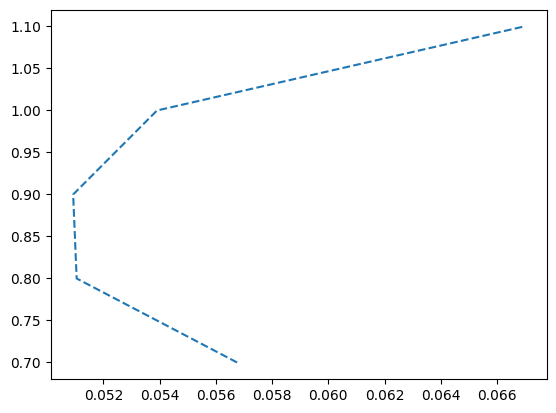

In [21]:
plt.plot(final_df["y"], final_df["x"], "--")

In [22]:
from scipy.interpolate import interp1d

In [23]:
risk = np.array(y)

In [24]:
return_ = np.array(x)

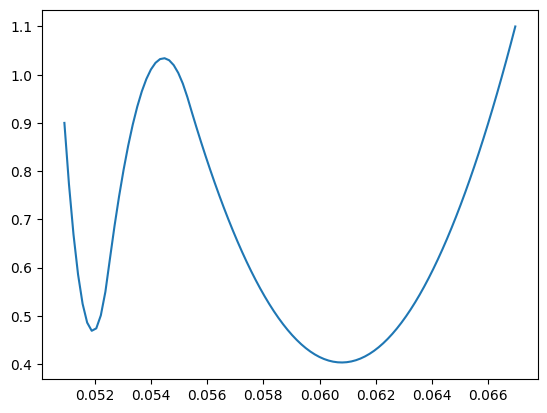

In [25]:
inter = interp1d(risk, return_, kind="quadratic")
risk_new = np.linspace(risk.min(), risk.max(), 100)
return_new = inter(risk_new)
# plt.plot(xnew, inter(xnew), '-')
plt.plot(risk_new, return_new, '-')

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
risk_poly = poly.fit_transform(risk.reshape(-1, 1))
X = risk_poly
y = return_

In [27]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [28]:
lr.score(X, y)

0.5040827944630565

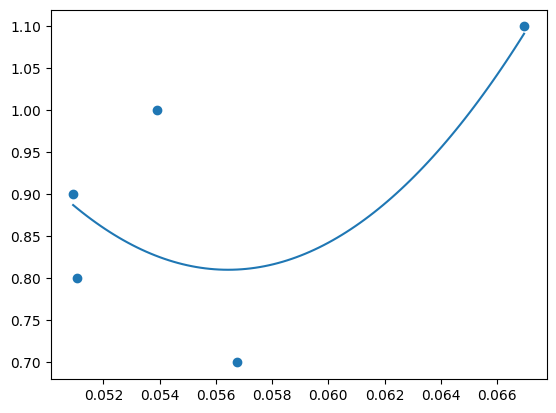

In [29]:
risk_new = np.linspace(risk.min(), risk.max(), 100)
risk_new_poly = poly.fit_transform(risk_new.reshape(-1, 1))
return_new = lr.predict(risk_new_poly)

plt.plot(risk_new, return_new, '-')
plt.scatter(risk, return_)

In [30]:
from scipy.signal import hilbert, chirp

In [31]:
duration = 1.0

fs = 400.0

samples = int(fs*duration)

t = np.arange(samples) / fs
signal = chirp(t, 20.0, t[-1], 100.0)

signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

In [32]:
analytic_signal = hilbert(p_expected_returns)

In [33]:
amplicitude_envelope = np.abs(analytic_signal)

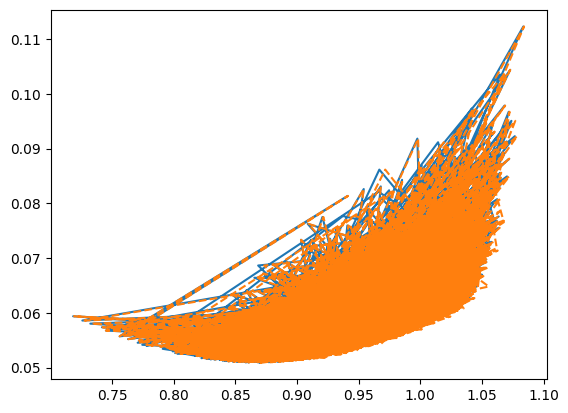

In [36]:
plt.plot(p_expected_returns, p_std)
plt.plot(amplicitude_envelope, p_std, '--')